# Differencing Attack

This section demonstrates some of the simplest possible attacks on an individual's private data and what differential privacy does to mitigate it.
We'll demonstrate the attack with public-use California income microdata.

In [1]:
import numpy as np
import opendp.prelude as dp
dp.enable_features('contrib') # OpenDP is vetting new features, so we need to enable them explicitly

data_path = dp.examples.get_california_pums_path()
var_names = ["age", "sex", "educ", "race", "income", "married"]
incomes = np.genfromtxt(data_path, delimiter=',', names=var_names)[:]['income'].tolist() # type: ignore

Say an attacker wants to know the income of the first person in our data (i.e. the first income in the csv). 
In our case, it happens to be `0`.

In [2]:
target_income = incomes[0]
target_income

0.0

One way the attacker could deduce the income of the target individual is by acquiring the following information:
1. the number of individuals in the dataset
2. the average income
3. the average income without the target individual

In [3]:
# attacker information:
n_individuals = len(incomes)
mean = float(np.mean(incomes))
mean_non_target = float(np.mean(incomes[1:]))

def reconstruct_income(n_individuals, mean, mean_non_target):
    """Reconstruct the target's income from the mean and the mean of the non-targets."""
    return mean * n_individuals - (n_individuals - 1) * mean_non_target

recovered_income = reconstruct_income(n_individuals, mean, mean_non_target)
recovered_income

0.0

These queries seem more benign than directly requesting the target's income.
The most suspicious of the three (mean without the target individual) 
could easily be hidden with more benign predicates that _just so happen_ to exclude one individual.

In general, it is impossible to anticipate how more complex combinations of queries could be used to violate the privacy of an individual in the data.
A further complicating factor is that data curators have no way of knowing what information adversaries are advantaged with,
when the data curator chooses whether to answer a query.

## Differential Privacy

Differential privacy mathematically guarantees that data released to the adversary 
will only increase the adversary's knowledge about any one individual by a small amount.
Therefore when the privacy parameters are appropriately tuned (a rule of thumb being $\epsilon = 1$), 
the adversary won't be able to infer the income of the target,
even when the adversary has access to unlimited auxiliary information.

Lets set up a mediator that the adversary can query that ensures the privacy loss will not exceed $\epsilon = 1$.

In [4]:
import polars as pl

context = dp.Context.compositor(
    data=pl.scan_csv(
        data_path,
        with_column_names=lambda _: var_names,
        infer_schema_length=None,
    ),
    privacy_unit=dp.unit_of(contributions=1),
    # allows the privacy loss of up to one epsilon for each individual in the data
    privacy_loss=dp.loss_of(epsilon=1.0),
    # the adversary will be able to ask two queries
    split_evenly_over=2,
    # in this case, it is public info that there are at most 1000 individuals in the data
    margins=[dp.polars.Margin(max_length=1000)]
)
# all further data access will be mediated by the context
del data_path

We'll start by assuming the adversary knows the number of individuals and average income.
The adversary also knows the target, so they know the target's age is 59 and has education status 9, 
which is enough to single out the target.
The adversary now sneakily requests the mean income for _everyone else_.

In [5]:
import polars as pl

query = (
    context.query()
    # matches everyone except the target
    .filter((pl.col.age != 59).or_(pl.col.educ != 9))
    .select(pl.col("income").cast(int).fill_null(0).dp.sum((0, 200_000)))
)
dp_non_target_income = query.release().collect().item()

dp_target_income = reconstruct_income(
    n_individuals,
    mean,
    # if the adversary uses the DP release to reconstruct the income, ...
    mean_non_target=dp_non_target_income / (n_individuals - 1),
)
# ...then the recovered income will be wildly inaccurate
dp_target_income

2425421.0

Even when the adversary was advantaged with auxiliary information, 
and all they needed was the total non-target income,
they still couldn't use the DP release to get a good estimate of the income.

Nonetheless, for an honest analyst, the estimate of the non-target income has reasonable utility:

In [6]:
# non-DP mean income, DP mean income
mean_non_target, dp_non_target_income / (n_individuals - 1)

(34414.4984984985, 31986.64964964965)

What if the analyst directly queries for the person of interest's income?
They plug in the known attributes as predicates, like age and education status, to single out the target.
They even make the greatest possible income level smaller, based on a best guess, to reduce the noise:

In [7]:
query = (
    context.query()
    .filter((pl.col.age == 59).and_(pl.col.educ == 9))
    .select(pl.col("income").cast(int).fill_null(0).dp.sum((0, 70_000)))
)
dp_target_income = query.release().collect().item()
dp_target_income

64914

Even though this query was explicitly crafted to single out the target, 
the estimate is still wildly inaccurate.

## Distribution of Outcomes
To demonstrate what differential privacy does to protect our data,
lets now take off the adversary hat, and put on the student hat.
As a student interested in learning about DP, and who is _not_ working with sensitive data, 
lets re-run the release multiple times to reveal the distribution of `dp_target_income`.

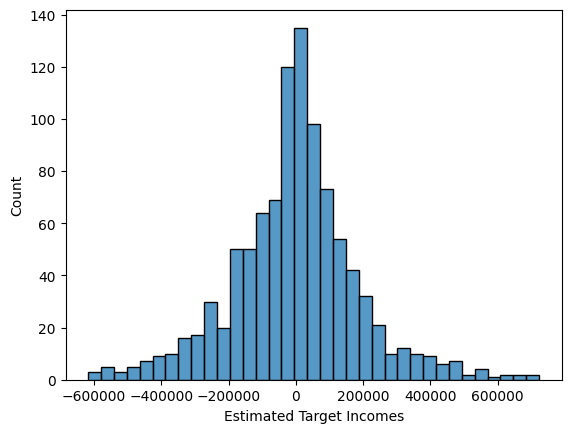

In [8]:
import seaborn as sns

m_target_income = query.resolve()
data = pl.scan_csv(
    dp.examples.get_california_pums_path(),
    with_column_names=lambda _: var_names,
    infer_schema_length=None,
)

# get estimates of overall means
dp_target_incomes = [m_target_income(data).collect().item() for _ in range(1_000)]
ax = sns.histplot(dp_target_incomes, edgecolor = 'black', linewidth = 1)
ax.set(xlabel = 'Estimated Target Incomes');

Notice how estimates of the estimates of the target's income vary wildly, 
but the answers are much more concentrated around the true income.
The adversary, only ever seeing one of these simulated releases, 
will have practically no better knowledge of the target's income than they did before,
even when the mechanism happens to release zero.

This is because the target can always appeal:
> My income wasn't actually zero! It was the noise! I practically made six figures!